In [1]:
import os
import math
import anndata
import numpy as np 
import scanpy as sc
import pandas as pd 
from PIL import Image
from pathlib import Path
from scipy.sparse import issparse, isspmatrix_csr, csr_matrix, spmatrix
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from tqdm import tqdm
import random

import torch
import torch.nn
import torchvision.models as models
from torch.autograd import Variable 
import torchvision.transforms as transforms

In [2]:
sp_data_folder = '151507'
adata = sc.read_visium(sp_data_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True)

adata.var_names_make_unique()
adata

/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

In [4]:
library_id = list(adata.uns["spatial"].keys())[0]
quality ='hires'
scale = adata.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"]
image_coor = adata.obsm["spatial"] * scale
adata.obs["imagecol"] = image_coor[:, 0]
adata.obs["imagerow"] = image_coor[:, 1]
adata.uns["spatial"][library_id]["use_quality"] = quality

image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"][library_id]["use_quality"]]

In [5]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import concurrent.futures

save_path = "images"
os.makedirs(save_path, exist_ok=True)
crop_size=120
target_size=448
verbose=False

if image.shape[2] == 3:
    img_pillow = Image.fromarray((image * 255).astype(np.uint8))
else:
    img_pillow = Image.fromarray(image)

def process_tile(imagerow, imagecol, crop_size, target_size, verbose=False):
    imagerow_down = imagerow - crop_size / 2
    imagerow_up = imagerow + crop_size / 2
    imagecol_left = imagecol - crop_size / 2
    imagecol_right = imagecol + crop_size / 2
    tile = img_pillow.crop((imagecol_left, imagerow_down, imagecol_right, imagerow_up))
    tile.thumbnail((target_size, target_size),Image.Resampling.LANCZOS)
    tile_name = f"{imagecol}-{imagerow}-{crop_size}.png"
    out_tile = Path(save_path) / tile_name
    if verbose:
        print(f"Generating tile at location ({imagecol}, {imagerow})")
    tile.save(out_tile, "PNG")
    return str(out_tile)

tile_names = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
        tile_name = executor.submit(
            process_tile, imagerow, imagecol, crop_size, target_size, verbose)
        tile_names.append(tile_name.result())

adata.obs["slices_path"] = tile_names


In [6]:
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras.callbacks import EarlyStopping

import numpy as np

import os
import cv2


image_dir = './images/'
image_files = os.listdir(image_dir)

images = []
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  

    if img is not None and img.shape == (120, 120):
        img = img.astype('float32') / 255.0  
        images.append(img)
    else:
        print(f"Skipping invalid image: {image_file}")

images = np.array(images)

image_matrix = images.reshape((images.shape[0], -1))

input_img = Input(shape=(14400,))  

encoded = Dense(1024, activation='relu')(input_img)
encoded = GaussianNoise(0.2)(encoded) 

encoded = Dense(512, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)

decoded = Dense(512, activation='relu')(encoded)
decoded = Dense(1024, activation='relu')(decoded)

decoded = Dense(14400, activation='relu')(decoded)  

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')  


history = autoencoder.fit(image_matrix, image_matrix,
                          epochs=450,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2
                        )

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(image_matrix)


Skipping invalid image: .DS_Store
Epoch 1/450
14/14 [==============================] - 1s 45ms/step - loss: 903.6303 - val_loss: 5875.8550
Epoch 2/450
14/14 [==============================] - 0s 26ms/step - loss: 19909.0938 - val_loss: 54641.8477
Epoch 3/450
14/14 [==============================] - 0s 25ms/step - loss: 53398.6055 - val_loss: 49247.7461
Epoch 4/450
14/14 [==============================] - 0s 25ms/step - loss: 60298.9766 - val_loss: 72276.3516
Epoch 5/450
14/14 [==============================] - 0s 25ms/step - loss: 81261.2891 - val_loss: 128569.3828
Epoch 6/450
14/14 [==============================] - 0s 25ms/step - loss: 201473.9531 - val_loss: 264591.2812
Epoch 7/450
14/14 [==============================] - 0s 25ms/step - loss: 226963.1875 - val_loss: 177925.3281
Epoch 8/450
14/14 [==============================] - 0s 25ms/step - loss: 125629.4922 - val_loss: 126356.9062
Epoch 9/450
14/14 [==============================] - 0s 25ms/step - loss: 157197.5312 - val_loss: 

In [7]:
adata.obsm["image_feat"] =encoded_imgs

In [8]:
import ot
from tensorflow.python.ops.numpy_ops import np_config
position = adata.obsm['spatial']
distance_matrix = ot.dist(position, position, metric='euclidean')


/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [9]:
n_spot = distance_matrix.shape[0]
adata.obsm['distance_matrix'] = distance_matrix

In [10]:
interaction = np.zeros([n_spot, n_spot]) 
for i in range(n_spot):
    vec = distance_matrix[i, :]
    distance = vec.argsort()
    for t in range(1,4):
        y = distance[t]
        interaction[i, y] = 1

In [11]:

adata.obsm['graph_neigh'] = interaction
adj = interaction
adj = adj + adj.T

In [12]:
adj = np.where(adj>1, 1, adj)
print("Binary Adjacency Matrix:")


Binary Adjacency Matrix:


In [13]:
adata.obsm['adj'] = adj
adata_Vars = adata[:, adata.var['highly_variable']]

In [14]:
feat=adata_Vars.X.toarray()[:, ]
image_feat=adata.obsm["image_feat"]

In [15]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat=adata_Vars.X.toarray()[:, ]
image_feat=adata.obsm["image_feat"]
image_feat_scaled = scaler.fit_transform(image_feat)
feat_scaled = scaler.fit_transform(feat)
n_components = 50  
pca_image_feat = PCA(n_components=n_components).fit_transform(image_feat_scaled)
pca_feat = PCA(n_components=n_components).fit_transform(feat_scaled)
combined_feat = np.concatenate((pca_image_feat, pca_feat), axis=1)
ids = np.arange(combined_feat.shape[0])
ids = np.random.permutation(ids)
feature_permutated = combined_feat[ids]
adata.obsm['combined_feat'] =combined_feat
adata.obsm['feat_a'] =feature_permutated
n_spot = adata.n_obs
one_matrix = np.ones([n_spot, 1])
zero_matrix = np.zeros([n_spot, 1])
label_CSL = np.concatenate([one_matrix, zero_matrix], axis=1)
adata.obsm['label_CSL'] = label_CSL

In [16]:
ids = np.arange(pca_image_feat.shape[0])
ids = np.random.permutation(ids)
feature_permutated = pca_image_feat[ids]
adata.obsm['feat_a'] =feature_permutated

In [17]:
n_spot = adata.n_obs
one_matrix = np.ones([n_spot, 1])
zero_matrix = np.zeros([n_spot, 1])
label_CSL = np.concatenate([one_matrix, zero_matrix], axis=1)
adata.obsm['label_CSL'] = label_CSL

In [18]:
import scipy.sparse as sp

adj = sp.coo_matrix(adj)
rowsum = np.array(adj.sum(1))
d_inv_sqrt = np.power(rowsum, -0.5).flatten()
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
a=adj.toarray()
adj_normalized = a+np.eye(adj.shape[0])

In [19]:
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix
import pandas as pd
import torch
device= torch.device('mps')

/var/folders/zt/c6n2w1f53ngbmqr21hfs1yhw0000gn/T/ipykernel_93380/1934589076.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/var/folders/zt/c6n2w1f53ngbmqr21hfs1yhw0000gn/T/ipykernel_93380/1934589076.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [20]:
features = torch.FloatTensor(adata.obsm['combined_feat'].copy()).to(device)
features_a = torch.FloatTensor(adata.obsm['feat_a'].copy()).to(device)
label_CSL = torch.FloatTensor(adata.obsm['label_CSL']).to(device)
graph_neigh = torch.FloatTensor(adata.obsm['graph_neigh'].copy() + np.eye(adj.shape[0])).to(device)
dim_input =features.shape[1]
dim_output = 64

In [21]:
from torch.nn.parameter import Parameter

weight1 = Parameter(torch.FloatTensor(dim_input, dim_output))
weight2 = Parameter(torch.FloatTensor(dim_output,dim_input))
torch.nn.init.xavier_uniform_(weight1)
torch.nn.init.xavier_uniform_(weight2)
from torch.nn.modules.module import Module

In [22]:
class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = c.expand_as(h_pl)  

        sc_1 = self.f_k(h_pl, c_x)
        sc_2 = self.f_k(h_mi, c_x)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits
    

In [23]:
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1)
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1) 
    

In [24]:
class Encoder(Module):
    def __init__(self, in_features, out_features, graph_neigh, dropout=0.0, act=F.relu):
        super(Encoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.graph_neigh = graph_neigh
        self.dropout = dropout
        self.act = act
        
        self.weight1 = Parameter(torch.FloatTensor(self.in_features, self.out_features))
        self.weight2 = Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.reset_parameters()
        self.linear_layer = nn.Linear(in_features, out_features)
        
        self.disc = Discriminator(self.out_features)

        self.sigm = nn.Sigmoid()
        self.read = AvgReadout()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight1)
        torch.nn.init.xavier_uniform_(self.weight2)

    def forward(self, feat, feat_a, adj):
        z = F.dropout(feat, self.dropout, self.training)
        z = torch.mm(z, self.weight1)
        z = torch.mm(adj, z)
        
        hiden_emb = z
        
        h = torch.mm(z, self.weight2)
        h = torch.mm(adj, h)
        
        emb = self.act(z)
        
        z_a = F.dropout(feat_a, self.dropout, self.training)
        z_a = torch.mm(z_a, self.weight1)
        z_a = torch.mm(adj, z_a)
        emb_a = self.act(z_a)
        
        g = self.read(emb, self.graph_neigh) 
        g = self.sigm(g)  

        g_a = self.read(emb_a, self.graph_neigh)
        g_a = self.sigm(g_a)  

        ret = self.disc(g, emb, emb_a)  
        ret_a = self.disc(g_a, emb_a, emb) 
        
        return hiden_emb, h, ret, ret_a
    

In [25]:
model = Encoder(dim_input, dim_output, graph_neigh).to(device)
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=42)
loss_CSL = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0025, 
                                          weight_decay=0.00)
model.train()
adj = torch.FloatTensor(adj_normalized).to(device)

In [26]:
for epoch in tqdm(range(600)):
        
        
        model.train()
        ids = np.arange(features.shape[0])
        ids = np.random.permutation(ids)
        features_a = features[ids]
              
        
        hiden_feat,emb, ret, ret_a = model(features,features_a,adj)
            
        loss_sl_1 =loss_CSL(ret, label_CSL)
        loss_sl_2 =loss_CSL(ret_a,label_CSL)
        loss_feat = F.mse_loss(features, emb)
            
        loss = 10*loss_feat + 1*(loss_sl_1 +loss_sl_2)
            
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        


100%|██████████| 600/600 [00:14<00:00, 40.46it/s]


In [28]:
emb_rec = model(features, features_a, adj)[1].detach().cpu().numpy()
adata.obsm['emb'] = emb_rec
pca = PCA(n_components=20, random_state=42)
embedding = pca.fit_transform(emb_rec.copy())
adata.obsm['emb_pca'] = embedding

use_rep = 'emb'
sc.pp.neighbors(adata, n_neighbors=50, use_rep=use_rep)

In [29]:
from sklearn import metrics
df_meta = pd.read_csv('151507/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['Ground_Truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['Ground_Truth'])]    

In [30]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('mclust')
np.random.seed(2020)
    
robjects.r.library("mclust")
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
r_random_seed = robjects.r['set.seed']
r_random_seed(2020)
rmclust = robjects.r['Mclust']
modelNames='EEE'

res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm['emb_pca']), 7, modelNames)
mclust_res = np.array(res[-2])

adata.obs['mclust'] = mclust_res
adata.obs['mclust'] = adata.obs['mclust'].astype('int')
adata.obs['mclust'] = adata.obs['mclust'].astype('category')

R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3/mclust_6.0.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 4255325 bytes (4.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso


The downloaded binary packages are in
	/var/folders/zt/c6n2w1f53ngbmqr21hfs1yhw0000gn/T//Rtmp283YOb/downloaded_packages


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/var/folders/zt/c6n2w1f53ngbmqr21hfs1yhw0000gn/T/ipykernel_93380/2051566017.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['mclust'] = mclust_res


In [31]:
ARI = metrics.adjusted_rand_score(adata.obs['mclust'], adata.obs['Ground_Truth'])
adata.uns['ARI'] = ARI
print('ARI:', ARI)

ARI: 0.43608660924228865


/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/abdullahalsakib/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


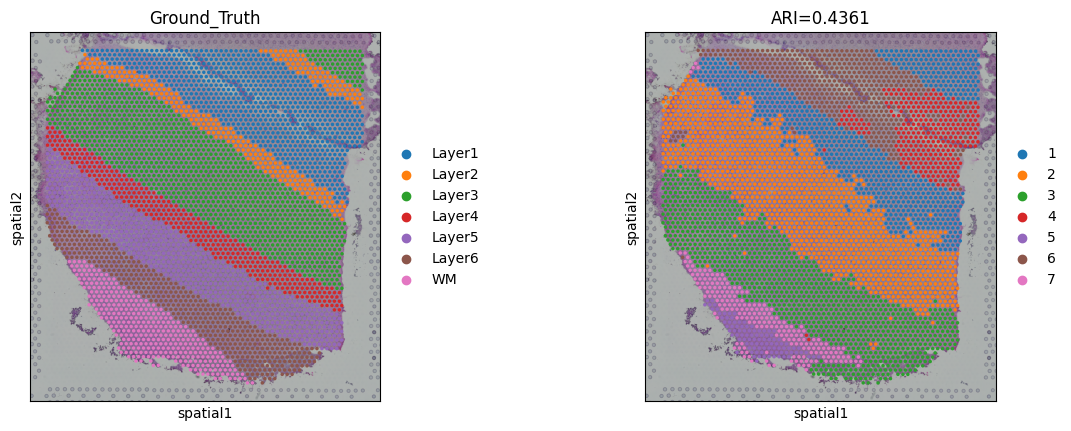

In [32]:
sc.pl.spatial(adata,
              img_key="hires",
              color=["Ground_Truth", "mclust"],
              title=["Ground_Truth", "ARI=%.4f"%ARI],
              show=True)

In [ ]:
adata.write_h5ad(filename='ari_4361.h5ad')
